# Feature Transformation with Scikit-Learn In This Notebook
## Saving Features into the SageMaker Feature Store



In [1]:
!pip install --disable-pip-version-check -q tensorflow==2.8.1
!pip install --disable-pip-version-check -q transformers==4.46.0
!pip install protobuf==3.20.*
import sagemaker
import boto3

sess = sagemaker.Session()
bucket = "cardiovale-solutions-datascience-pipeline"
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.8.1


/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# Prepare the data

In [2]:
import pandas as pd
import boto3
import sagemaker
from sagemaker import get_execution_role
from pyathena import connect

# Setup AWS session
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
bucket = "cardiovale-solutions-datascience-pipeline"  # Your actual S3 bucket
role = get_execution_role()

# Connect to Athena
conn = connect(s3_staging_dir=f"s3://{bucket}/athena/staging/", region_name=region)

# Fetch `cardio_train_cleaned` dataset
query = "SELECT * FROM cardiovale_db.cardio_train_cleaned"
df_cardio = pd.read_sql(query, conn)

print("Successfully loaded cardio_train_cleaned from Athena")
print(df_cardio.head())


/tmp/ipykernel_7380/3809400061.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cardio = pd.read_sql(query, conn)


Successfully loaded cardio_train_cleaned from Athena
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [3]:
df_cardio.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [4]:
#fetch quitline_fixed_.csv
query = "SELECT * FROM cardiovale_db.quitline_fixed LIMIT 5"
df_quitline = pd.read_sql(query, conn)

print("Successfully loaded quitline_fixed from Athena")
print(df_quitline.head())


/tmp/ipykernel_7380/126416555.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_quitline = pd.read_sql(query, conn)


Successfully loaded quitline_fixed from Athena
   year  date date_ref locationabbr locationdesc topictype  \
0  2020    12  Jul-Dec           GA      Georgia  Quitline   
1  2020    12  Jul-Dec           MO     Missouri  Quitline   
2  2020    12  Jul-Dec           MT      Montana  Quitline   
3  2020    12  Jul-Dec           NJ   New Jersey  Quitline   
4  2020    12  Jul-Dec           OK     Oklahoma  Quitline   

            topicdesc  measuredesc         sub_measure              variable  \
0  Services Available  Medications    Nicotine Lozenge                   nan   
1  Services Available  Medications    Nicotine Lozenge                   nan   
2  Services Available  Medications  Bupropion (Zyban®)                   nan   
3  Services Available  Medications    Nicotine Lozenge                   nan   
4  Services Available  Medications        Nicotine Gum  All Eligible Callers   

   ... number_of_weeks_offered    limit_per_year comments  \
0  ...                     NaN        

In [5]:
df_quitline.columns

Index(['year', 'date', 'date_ref', 'locationabbr', 'locationdesc', 'topictype',
       'topicdesc', 'measuredesc', 'sub_measure', 'variable',
       'offered_for_free', 'offered_for_free_text', 'geographic_requirements',
       'geographic_requirements_text', 'age_requirements',
       'age_requirements_text', 'readiness_to_quit_requirements',
       'readiness_to_quit_requirements_text', 'counseling_requirements',
       'counseling_requirements_text', 'physician_approval_required',
       'physician_approval_required_text', 'medical_restrictions',
       'medical_restrictions_text', 'insurance_requirements',
       'insurance_requirements_text', 'other_requirements',
       'other_requirements_text', 'limited_supply', 'limited_supply_text',
       'unlimited_weeks_offered', 'number_of_weeks_offered', 'limit_per_year',
       'comments', 'geolocation', 'topictypeid', 'topicid', 'measureid',
       'source', 'submeasureid', 'displayorder'],
      dtype='object')

In [6]:
# --------------------------------------
# The cardio dataset does not have a 'State' column, but the quitline dataset is state-based.
# To merge both datasets, we randomly assign a state to each row in the cardio dataset.
# This ensures we can associate each patient with state-level quitline data.
# Note: This is an artificial assignment and does not reflect real patient locations.

import random

# Use correct column name from quitline dataset
state_column = "locationabbr"

# Extract unique state abbreviations (like 'CA', 'NY') from quitline data
states = df_quitline[state_column].dropna().unique().tolist()

# Assign a random state to each row in cardio data for merging
df_cardio["State"] = [random.choice(states) for _ in range(len(df_cardio))]

# --------------------------------------
# Aggregating Quitline Data
# ----------------------------
# Summarize quitline data per state:
# - % of entries offering treatment for free
# - % of entries with medical restrictions
# - Average number of weeks offered

df_quitline_summary = df_quitline.groupby(state_column).agg({
    "offered_for_free": lambda x: (x == "Yes").mean(),        # e.g., 0.85 = 85% states offer it for free
    "medical_restrictions": lambda x: (x == "Yes").mean(),    # e.g., 0.40 = 40% states have restrictions
    "number_of_weeks_offered": "mean"                         # average weeks offered
}).reset_index()

# Rename for consistency with df_cardio's 'State'
df_quitline_summary.rename(columns={
    state_column: "State",
    "offered_for_free": "Offered_for_Free",
    "medical_restrictions": "Medical_Restrictions",
    "number_of_weeks_offered": "Number_of_Weeks_Offered"
}, inplace=True)

# --------------------------------------
# Merging Data
# ----------------------------
# Merge cardio data with summarized quitline data using 'State' as the key

df_merged = df_cardio.merge(df_quitline_summary, on="State", how="left")

# Handle missing state-level data (just in case)
df_merged["Number_of_Weeks_Offered"].fillna(0, inplace=True)

# Convert 'State' to categorical for feature store
df_merged["State"] = df_merged["State"].astype("category")


/tmp/ipykernel_7380/2642915367.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged["Number_of_Weeks_Offered"].fillna(0, inplace=True)


In [7]:
# Rename columns to match Feature Store definition
df_merged.rename(columns={
    "Offered_for_Free": "offered_for_free",
    "Medical_Restrictions": "medical_restrictions",
    "Number_of_Weeks_Offered": "number_of_weeks_offered"
}, inplace=True)

df_merged.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,State,offered_for_free,medical_restrictions,number_of_weeks_offered
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,OK,1.0,1.0,2.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,GA,0.0,0.0,0.0
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,OK,1.0,1.0,2.0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,MT,1.0,0.0,0.0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,OK,1.0,1.0,2.0


In [8]:
df_merged.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'State',
       'offered_for_free', 'medical_restrictions', 'number_of_weeks_offered'],
      dtype='object')

## Feature Store requires an Event Time feature


In [9]:
from time import gmtime, strftime
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum
from datetime import datetime
import time

# 1. Generate a unique name using timestamp
timestamp = strftime("%d-%H-%M-%S", gmtime())
feature_group_name = f"cardio-feature-group-{timestamp}"

# 2. Define feature schema (make sure all columns in df_merged match these names & types exactly)
feature_definitions = [
    FeatureDefinition("id", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("age", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("gender", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("height", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("weight", FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition("ap_hi", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("ap_lo", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("cholesterol", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("gluc", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("smoke", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("alco", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("active", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("cardio", FeatureTypeEnum.INTEGRAL),
    FeatureDefinition("State", FeatureTypeEnum.STRING),
    FeatureDefinition("offered_for_free", FeatureTypeEnum.FRACTIONAL),  # updated to match lowercase
    FeatureDefinition("medical_restrictions", FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition("number_of_weeks_offered", FeatureTypeEnum.FRACTIONAL),
    FeatureDefinition("event_time", FeatureTypeEnum.STRING),
    FeatureDefinition("split_type", FeatureTypeEnum.STRING),
]

# 3. Create the FeatureGroup object
feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session,
    feature_definitions=feature_definitions
)

# 4. Create the feature group in SageMaker Feature Store
feature_group.create(
    record_identifier_name="id",
    event_time_feature_name="event_time",
    role_arn=role,
    s3_uri=f"s3://{bucket}/feature-store/cardio/{feature_group_name}",
    enable_online_store=False,
)

# 5. Wait until Feature Group is ready
while feature_group.describe()["FeatureGroupStatus"] == "Creating":
    print("Waiting for feature group creation...")
    time.sleep(5)

# 6. Add `event_time` column before ingestion (this is crucial!)
df_merged["event_time"] = datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ")

# 7. Add split_type for SageMaker Autopilot compatibility
df_merged["split_type"] = "train"

# 8. Ingest data into feature store
feature_group.ingest(data_frame=df_merged, max_workers=3, wait=True)


Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...


IngestionManagerPandas(feature_group_name='cardio-feature-group-05-21-19-28', feature_definitions={'id': {'FeatureName': 'id', 'FeatureType': 'Integral'}, 'age': {'FeatureName': 'age', 'FeatureType': 'Integral'}, 'gender': {'FeatureName': 'gender', 'FeatureType': 'Integral'}, 'height': {'FeatureName': 'height', 'FeatureType': 'Integral'}, 'weight': {'FeatureName': 'weight', 'FeatureType': 'Fractional'}, 'ap_hi': {'FeatureName': 'ap_hi', 'FeatureType': 'Integral'}, 'ap_lo': {'FeatureName': 'ap_lo', 'FeatureType': 'Integral'}, 'cholesterol': {'FeatureName': 'cholesterol', 'FeatureType': 'Integral'}, 'gluc': {'FeatureName': 'gluc', 'FeatureType': 'Integral'}, 'smoke': {'FeatureName': 'smoke', 'FeatureType': 'Integral'}, 'alco': {'FeatureName': 'alco', 'FeatureType': 'Integral'}, 'active': {'FeatureName': 'active', 'FeatureType': 'Integral'}, 'cardio': {'FeatureName': 'cardio', 'FeatureType': 'Integral'}, 'State': {'FeatureName': 'State', 'FeatureType': 'String'}, 'offered_for_free': {'Fea

## Describe the Feature Group

In [10]:
feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:424808199142:feature-group/cardio-feature-group-05-21-19-28',
 'FeatureGroupName': 'cardio-feature-group-05-21-19-28',
 'RecordIdentifierFeatureName': 'id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'id', 'FeatureType': 'Integral'},
  {'FeatureName': 'age', 'FeatureType': 'Integral'},
  {'FeatureName': 'gender', 'FeatureType': 'Integral'},
  {'FeatureName': 'height', 'FeatureType': 'Integral'},
  {'FeatureName': 'weight', 'FeatureType': 'Fractional'},
  {'FeatureName': 'ap_hi', 'FeatureType': 'Integral'},
  {'FeatureName': 'ap_lo', 'FeatureType': 'Integral'},
  {'FeatureName': 'cholesterol', 'FeatureType': 'Integral'},
  {'FeatureName': 'gluc', 'FeatureType': 'Integral'},
  {'FeatureName': 'smoke', 'FeatureType': 'Integral'},
  {'FeatureName': 'alco', 'FeatureType': 'Integral'},
  {'FeatureName': 'active', 'FeatureType': 'Integral'},
  {'FeatureName': 'cardio', 'FeatureType': 'Integral'},
  {'FeatureN

In [11]:
# Review sample of data to be ingested into Feature Store
df_merged.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,State,offered_for_free,medical_restrictions,number_of_weeks_offered,event_time,split_type
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,OK,1.0,1.0,2.0,2025-04-05T21:19:55Z,train
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,GA,0.0,0.0,0.0,2025-04-05T21:19:55Z,train
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,OK,1.0,1.0,2.0,2025-04-05T21:19:55Z,train
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,MT,1.0,0.0,0.0,2025-04-05T21:19:55Z,train
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,OK,1.0,1.0,2.0,2025-04-05T21:19:55Z,train


In [12]:
print(df_merged.shape)
print(df_merged.dtypes)


(70000, 19)
id                            int64
age                           int64
gender                        int64
height                        int64
weight                      float64
ap_hi                         int64
ap_lo                         int64
cholesterol                   int64
gluc                          int64
smoke                         int64
alco                          int64
active                        int64
cardio                        int64
State                      category
offered_for_free            float64
medical_restrictions        float64
number_of_weeks_offered     float64
event_time                   object
split_type                   object
dtype: object


# Cast DataFrame `Object` to Supported Feature Store Data Type `String`

In [13]:
# Cast all 'object' columns to string for Feature Store compatibility
for col in df_merged.select_dtypes(include='object').columns:
    df_merged[col] = df_merged[col].astype(str)


In [14]:
df_merged

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,State,offered_for_free,medical_restrictions,number_of_weeks_offered,event_time,split_type
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,OK,1.0,1.0,2.0,2025-04-05T21:19:55Z,train
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,GA,0.0,0.0,0.0,2025-04-05T21:19:55Z,train
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,OK,1.0,1.0,2.0,2025-04-05T21:19:55Z,train
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,MT,1.0,0.0,0.0,2025-04-05T21:19:55Z,train
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,OK,1.0,1.0,2.0,2025-04-05T21:19:55Z,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,MT,1.0,0.0,0.0,2025-04-05T21:19:55Z,train
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,GA,0.0,0.0,0.0,2025-04-05T21:19:55Z,train
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,MO,0.0,0.0,0.0,2025-04-05T21:19:55Z,train
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,NJ,1.0,0.0,0.0,2025-04-05T21:19:55Z,train


# Check for imbalance in the target variable

In [15]:
df_merged['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

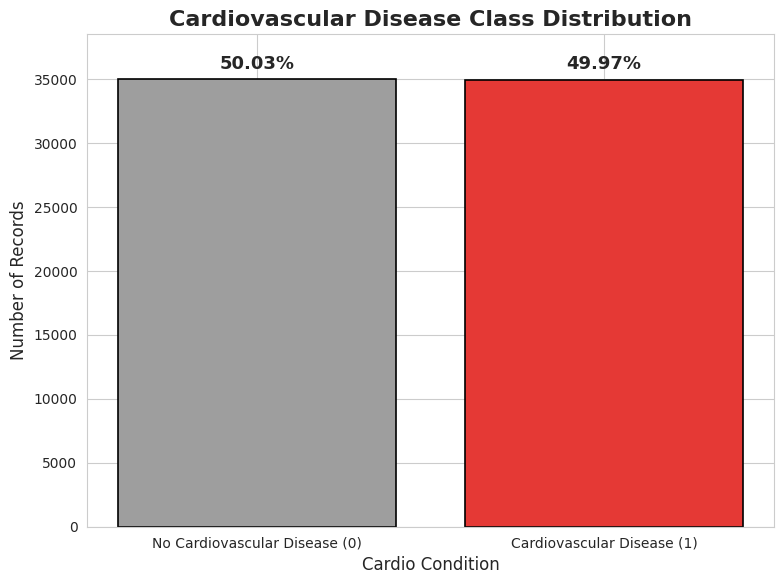

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------
# Cardiovascular Class Count with Percentage Labels
# -----------------------------

# Define brand colors
RED = "#E53935"      # Strong red
GRAY = "#9E9E9E"     # Soft gray
BLACK = "#000000"    # For edges and text

# Set font and style
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Output directory
images_path = "../images" if os.path.exists("../images") else "images"
os.makedirs(images_path, exist_ok=True)

# Get actual class counts
class_counts = df_merged['cardio'].value_counts().sort_index()
total = class_counts.sum()
labels = ['No Cardiovascular Disease (0)', 'Cardiovascular Disease (1)']
colors = [GRAY, RED]

# Plot
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

bars = plt.bar(labels, class_counts, color=colors, edgecolor=BLACK, linewidth=1.2)

# Add % labels on top of each bar
for bar, count in zip(bars, class_counts):
    percentage = count / total
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        count + 500,  # a bit above bar height
        f"{percentage:.2%}",
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

# Final touches
plt.ylabel("Number of Records")
plt.xlabel("Cardio Condition")
plt.title("Cardiovascular Disease Class Distribution", fontsize=16, fontweight='bold')
plt.ylim(0, max(class_counts) * 1.10)
plt.tight_layout()

# Save
plt.savefig(f"{images_path}/class_distribution_counts_and_pct.png", dpi=300)
plt.show()


# Build Training/ test Dataset

In [17]:
import pandas as pd
import io
import boto3
from sklearn.model_selection import train_test_split

# 1. Setup S3 client
s3 = boto3.client("s3")

# 2. Define bucket and prefix from describe() output
bucket = "cardiovale-solutions-datascience-pipeline"
prefix = "feature-store/cardio/cardio-feature-group-22-21-14-34"

# 3. Split df_merged into train, validation, and test
train_df, temp_df = train_test_split(df_merged, test_size=0.3, random_state=42, stratify=df_merged["cardio"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["cardio"])

# 4. Assign split_type
train_df["split_type"] = "train"
val_df["split_type"] = "validation"
test_df["split_type"] = "test"

# 5. Concatenate all splits for upload (Autopilot expects one file)
df_with_split = pd.concat([train_df, val_df, test_df], axis=0)

# 6. Save to S3 as CSV for Autopilot
csv_buffer = io.StringIO()
df_with_split.to_csv(csv_buffer, index=False)

s3.put_object(
    Bucket=bucket,
    Key=f"{prefix}/autopilot_input.csv",
    Body=csv_buffer.getvalue()
)

print("Final dataset with splits uploaded to S3.")


Final dataset with splits uploaded to S3.


# Create An Athena Query

In [18]:
feature_store_query = feature_group.athena_query()

# Get The Feature Group Table Name

In [19]:
feature_store_table = feature_store_query.table_name

# Build an Athena SQL Query

In [20]:
print(feature_group.as_hive_ddl())

CREATE EXTERNAL TABLE IF NOT EXISTS sagemaker_featurestore.cardio-feature-group-05-21-19-28 (
  id INT
  age INT
  gender INT
  height INT
  weight FLOAT
  ap_hi INT
  ap_lo INT
  cholesterol INT
  gluc INT
  smoke INT
  alco INT
  active INT
  cardio INT
  State STRING
  offered_for_free FLOAT
  medical_restrictions FLOAT
  number_of_weeks_offered FLOAT
  event_time STRING
  split_type STRING
  write_time TIMESTAMP
  event_time TIMESTAMP
  is_deleted BOOLEAN
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
  STORED AS
  INPUTFORMAT 'parquet.hive.DeprecatedParquetInputFormat'
  OUTPUTFORMAT 'parquet.hive.DeprecatedParquetOutputFormat'
LOCATION 's3://cardiovale-solutions-datascience-pipeline/feature-store/cardio/cardio-feature-group-05-21-19-28/424808199142/sagemaker/us-east-1/offline-store/cardio-feature-group-05-21-19-28-1743887968/data'


In [21]:
# Step 3: Build the SQL query for training data
query_string = """
SELECT id, age, gender, height, weight, ap_hi, ap_lo,
       cholesterol, gluc, smoke, alco, active, cardio,
       State, offered_for_free, medical_restrictions, number_of_weeks_offered
FROM "{}"
WHERE split_type = 'train'
LIMIT 5
""".format(feature_store_table)

print("Running: " + query_string)

Running: 
SELECT id, age, gender, height, weight, ap_hi, ap_lo,
       cholesterol, gluc, smoke, alco, active, cardio,
       State, offered_for_free, medical_restrictions, number_of_weeks_offered
FROM "cardio_feature_group_05_21_19_28_1743887968"
WHERE split_type = 'train'
LIMIT 5



In [22]:
query_string = """
SELECT id, age, gender, height, weight, ap_hi, ap_lo,
       cholesterol, gluc, smoke, alco, active, cardio,
       State, offered_for_free, medical_restrictions, number_of_weeks_offered,
       split_type
FROM "{}"
WHERE split_type = 'train'
LIMIT 5
""".format(feature_store_table)

## Run Athena Query
The query results are stored in a S3 bucket.

In [23]:
feature_store_query.run(query_string=query_string, output_location="s3://" + bucket + "/" + prefix + "/query_results/")
feature_store_query.wait()


[04/05/25 21:23:37] INFO     Query 1cc5eddb-7b7a-4f6c-83bc-2e88a42505a8 is being executed.          ]8;id=596242;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=411191;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#6745\6745]8;;\

[04/05/25 21:23:42] INFO     Query 1cc5eddb-7b7a-4f6c-83bc-2e88a42505a8 successfully executed.      ]8;id=358820;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=311708;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#6754\6754]8;;\

In [24]:
df = pd.DataFrame()

df = feature_store_query.as_dataframe()

df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,State,offered_for_free,medical_restrictions,number_of_weeks_offered,split_type


# Release Resources

In [25]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [26]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>